In [1]:
# Import required libraries
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import pandas as pd
import matplotlib.pyplot as plt

c:\Users\MSI\MachineLearning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import torch

In [3]:

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

tokenizer = AutoTokenizer.from_pretrained("Salesforce/codegen-350M-mono")
model = AutoModelForCausalLM.from_pretrained("Salesforce/codegen-350M-mono")
model = model.to(device)
model.eval()

Using device: cuda


Some weights of the model checkpoint at Salesforce/codegen-350M-mono were not used when initializing CodeGenForCausalLM: ['transformer.h.0.attn.causal_mask', 'transformer.h.1.attn.causal_mask', 'transformer.h.10.attn.causal_mask', 'transformer.h.11.attn.causal_mask', 'transformer.h.12.attn.causal_mask', 'transformer.h.13.attn.causal_mask', 'transformer.h.14.attn.causal_mask', 'transformer.h.15.attn.causal_mask', 'transformer.h.16.attn.causal_mask', 'transformer.h.17.attn.causal_mask', 'transformer.h.18.attn.causal_mask', 'transformer.h.19.attn.causal_mask', 'transformer.h.2.attn.causal_mask', 'transformer.h.3.attn.causal_mask', 'transformer.h.4.attn.causal_mask', 'transformer.h.5.attn.causal_mask', 'transformer.h.6.attn.causal_mask', 'transformer.h.7.attn.causal_mask', 'transformer.h.8.attn.causal_mask', 'transformer.h.9.attn.causal_mask']
- This IS expected if you are initializing CodeGenForCausalLM from the checkpoint of a model trained on another task or with another architecture (e

CodeGenForCausalLM(
  (transformer): CodeGenModel(
    (wte): Embedding(51200, 1024)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-19): 20 x CodeGenBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): CodeGenAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (qkv_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=False)
        )
        (mlp): CodeGenMLP(
          (fc_in): Linear(in_features=1024, out_features=4096, bias=True)
          (fc_out): Linear(in_features=4096, out_features=1024, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=51200, bias=True)
)

In [4]:
# Load CodeBERT tokenizer for masking
from transformers import RobertaTokenizer

print("Loading CodeBERT tokenizer...")
codebert_tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base-mlm")
print(f"CodeBERT mask token: {codebert_tokenizer.mask_token}")
print(f"CodeBERT mask token ID: {codebert_tokenizer.mask_token_id}")

# Load CodeBERT model for perturbation
from transformers import RobertaForMaskedLM

print("Loading CodeBERT model for perturbation...")
codebert_model = RobertaForMaskedLM.from_pretrained("microsoft/codebert-base-mlm")
codebert_model = codebert_model.to(device)
codebert_model.eval()
print(f"CodeBERT model loaded on {device}")

Loading CodeBERT tokenizer...
CodeBERT mask token: <mask>
CodeBERT mask token ID: 50264
Loading CodeBERT model for perturbation...
Loading CodeBERT model for perturbation...


Some weights of the model checkpoint at microsoft/codebert-base-mlm were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CodeBERT model loaded on cuda


In [5]:
def estimate_token_probabilities(code, tokenizer, model, window_size=2048, stride=512):
    """
    Estimate probability of each token using sliding window approach.
    
    Args:
        code: Input code string
        tokenizer: HuggingFace tokenizer
        model: HuggingFace causal LM model
        window_size: Size of each sliding window (default: 2048)
        stride: Step size for sliding (default: 512)
    
    Returns:
        List of dictionaries with token, position, probability, and line number
    """
    # Get device from model
    device = next(model.parameters()).device
    
    # Tokenize the entire code
    tokens = tokenizer(code, return_tensors="pt").input_ids[0]
    n_tokens = len(tokens)
    
    # Create mapping from character position to line number
    lines = code.split('\n')
    char_to_line = []
    char_pos = 0
    for line_num, line in enumerate(lines, 1):
        for _ in range(len(line) + 1):  # +1 for newline character
            char_to_line.append(line_num)
        char_pos += len(line) + 1
    
    # Map each token to its line number
    token_to_line = {}
    current_pos = 0
    for i, token_id in enumerate(tokens):
        token_text = tokenizer.decode([token_id])
        # Find this token in the original code
        if current_pos < len(char_to_line):
            token_to_line[i] = char_to_line[min(current_pos, len(char_to_line) - 1)]
        else:
            token_to_line[i] = len(lines)
        current_pos += len(token_text)
    
    # Store probabilities for each token (we'll average overlapping predictions)
    token_probs = {}  # {position: [prob1, prob2, ...]}
    
    print(f"Total tokens: {n_tokens}")
    print(f"Processing with window_size={window_size}, stride={stride}")
    
    # Slide window across the sequence
    for start_idx in range(0, n_tokens, stride):
        end_idx = min(start_idx + window_size, n_tokens)
        window_tokens = tokens[start_idx:end_idx].to(device)
        
        # Need at least 2 tokens to predict
        if len(window_tokens) < 2:
            break
        
        # Forward pass through model
        with torch.no_grad():
            outputs = model(window_tokens.unsqueeze(0), labels=window_tokens.unsqueeze(0))
            logits = outputs.logits
        
        # logits[0, i] predicts token at position i+1
        # So we shift: predictions for positions [start_idx+1, ..., end_idx]
        shift_logits = logits[0, :-1, :]  # Shape: [seq_len-1, vocab_size]
        shift_labels = window_tokens[1:]   # Shape: [seq_len-1]
        
        # Convert logits to probabilities
        probs = torch.softmax(shift_logits, dim=-1)
        
        # Get probability of actual next token at each position
        actual_probs = torch.gather(probs, 1, shift_labels.unsqueeze(1)).squeeze(1)
        
        # Store probabilities for each position (move to CPU for storage)
        for i, prob in enumerate(actual_probs):
            pos = start_idx + i + 1  # Actual position in full sequence
            if pos not in token_probs:
                token_probs[pos] = []
            token_probs[pos].append(prob.cpu().item())
        
        # Break if we've covered the entire sequence
        if end_idx >= n_tokens:
            break
    
    # Average probabilities where we have multiple predictions
    results = []
    
    # First, add the first token (position 0) with probability 1.0 (no prior context to predict it)
    if n_tokens > 0:
        token_id = tokens[0].item()
        token_text = tokenizer.decode([token_id])
        line_num = token_to_line.get(0, 1)
        
        results.append({
            "position": 0,
            "line": line_num,
            "token_id": token_id,
            "token": repr(token_text),
            "probability": 1.0,  # First token has no prior context, so we assign prob=1.0
            "log_prob": 0.0,     # log(1.0) = 0.0
            "num_predictions": 0  # No predictions for first token
        })
    
    # Now add all other tokens with their computed probabilities
    for pos in sorted(token_probs.keys()):
        token_id = tokens[pos].item()
        token_text = tokenizer.decode([token_id])
        avg_prob = sum(token_probs[pos]) / len(token_probs[pos])
        line_num = token_to_line.get(pos, 0)
        
        results.append({
            "position": pos,
            "line": line_num,
            "token_id": token_id,
            "token": repr(token_text),
            "probability": avg_prob,
            "log_prob": torch.log(torch.tensor(avg_prob)).item(),
            "num_predictions": len(token_probs[pos])  # How many windows predicted this
        })
    
    return results, tokens

In [6]:

test_code_path = r"C:\Users\MSI\Downloads\inferencing\code.py"
with open(test_code_path, encoding="utf-8") as f:
    content = f.read()# Estimate probabilities
results, tokens = estimate_token_probabilities(content, tokenizer, model, window_size=2048, stride=512)

# Convert to DataFrame for nice display
df = pd.DataFrame(results)
print(f"\nTokens tensor shape: {tokens.shape}")
print(f"Total tokens: {len(tokens)}")
df.head(80)

Total tokens: 810
Processing with window_size=2048, stride=512

Tokens tensor shape: torch.Size([810])
Total tokens: 810

Tokens tensor shape: torch.Size([810])
Total tokens: 810


,position,line,token_id,token,probability,log_prob,num_predictions
0,0,1,11748,'import',1.000000,0.000000,0
1,1,1,18931,' logging',0.022740,-3.783614,1
2,2,1,198,'\n',0.932518,-0.069867,1
3,3,2,11748,'import',0.607801,-0.497907,1
4,4,2,25064,' sys',0.043855,-3.126875,1
...,...,...,...,...,...,...,...
75,75,13,9288,'test',0.826804,-0.190188,1
76,76,13,11250,'config',0.988266,-0.011804,1
77,77,13,2599,'):',0.929990,-0.072581,1
78,78,13,198,'\n',0.986153,-0.013944,1


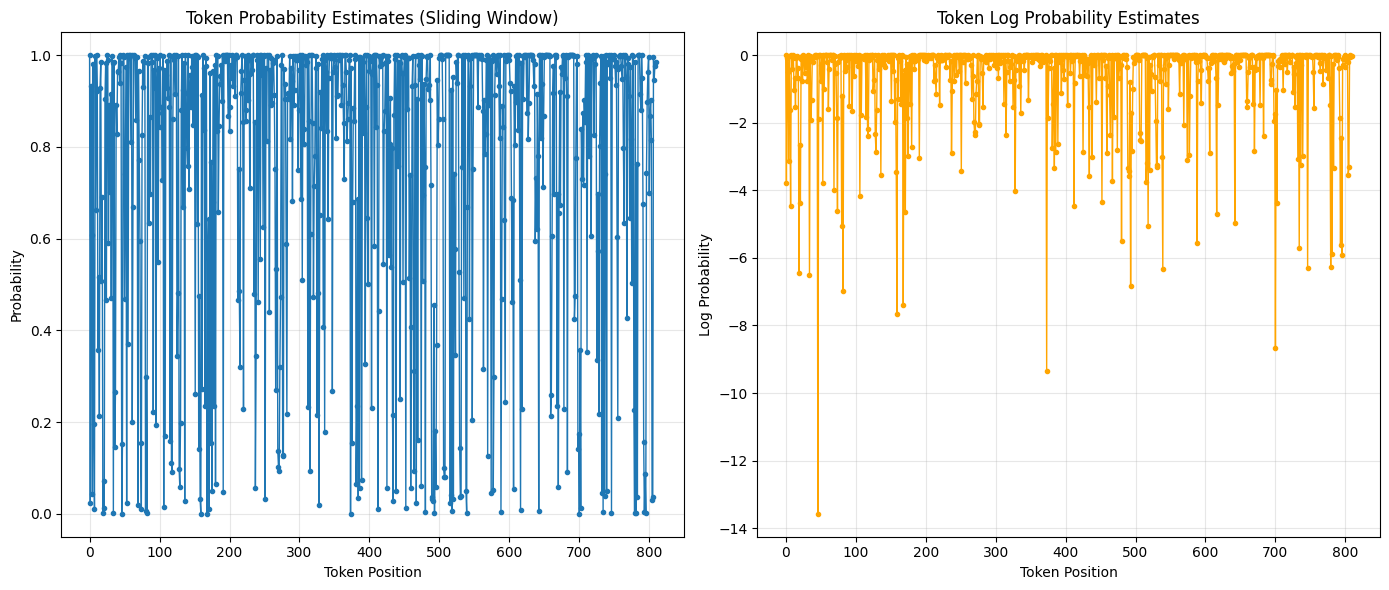


Summary Statistics:
Mean Probability: 0.7537
Median Probability: 0.9340
Min Probability: 0.0000
Max Probability: 1.0000

Total Log Probability: -531.4383
Perplexity: 1.9273


In [7]:
# Visualize the probabilities
plt.figure(figsize=(14, 6))

# Plot probability
plt.subplot(1, 2, 1)
plt.plot(df['position'], df['probability'], marker='o', markersize=3, linestyle='-', linewidth=1)
plt.xlabel('Token Position')
plt.ylabel('Probability')
plt.title('Token Probability Estimates (Sliding Window)')
plt.grid(True, alpha=0.3)

# Plot log probability
plt.subplot(1, 2, 2)
plt.plot(df['position'], df['log_prob'], marker='o', markersize=3, linestyle='-', linewidth=1, color='orange')
plt.xlabel('Token Position')
plt.ylabel('Log Probability')
plt.title('Token Log Probability Estimates')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show summary statistics
print(f"\nSummary Statistics:")
print(f"Mean Probability: {df['probability'].mean():.4f}")
print(f"Median Probability: {df['probability'].median():.4f}")
print(f"Min Probability: {df['probability'].min():.4f}")
print(f"Max Probability: {df['probability'].max():.4f}")
print(f"\nTotal Log Probability: {df['log_prob'].sum():.4f}")
print(f"Perplexity: {torch.exp(-torch.tensor(df['log_prob'].mean())).item():.4f}")

In [8]:
# Calculate perplexity for each line
# PPL(L_i) = e^(-1/N * Σ log p(w_j | w_1, w_2, ..., w_j-1))

# Group tokens by line
line_stats = df.groupby('line').agg({
    'log_prob': ['sum', 'count'],  # Sum of log probs and count of tokens
    'probability': 'mean'  # Mean probability (optional)
}).reset_index()

# Flatten column names
line_stats.columns = ['line', 'log_prob_sum', 'num_tokens', 'avg_prob']

# Calculate perplexity for each line using the formula
# PPL(L_i) = exp(-1/N * Σ log p(w_j))
line_stats['perplexity'] = line_stats.apply(
    lambda row: torch.exp(torch.tensor(-row['log_prob_sum'] / row['num_tokens'])).item() 
    if row['num_tokens'] > 0 else float('inf'), 
    axis=1
)

# Get the actual line content from the original code
code_lines = content.split('\n')
line_stats['line_content'] = line_stats['line'].apply(
    lambda x: code_lines[x-1] if 1 <= x <= len(code_lines) else ''

)

# Reorder columns for better readability
line_stats = line_stats[['line', 'num_tokens', 'perplexity', 'avg_prob', 'log_prob_sum', 'line_content']]
print("Per-Line Perplexity Analysis:")
print("=" * 100)
line_stats

Per-Line Perplexity Analysis:


,line,num_tokens,perplexity,avg_prob,log_prob_sum,line_content
0,1,3,3.612839,0.651753,-3.853481,import logging
1,2,3,3.368718,0.544339,-3.643596,import sys
2,3,6,3.000586,0.631601,-6.592845,from io import StringIO
3,4,1,2.807144,0.356234,-1.032167,
4,5,4,1.773974,0.661083,-2.292889,import pytest
...,...,...,...,...,...,...
73,94,11,1.214559,0.849153,-2.138193,assert rv.status_code == 500
74,95,7,3.445559,0.645993,-8.659603,assert rv.data
75,96,9,2.948866,0.731173,-9.732785,err = stream.getvalue()
76,97,12,4.144405,0.598268,-17.061112,"assert ""Exception on / [GET]"" in err"


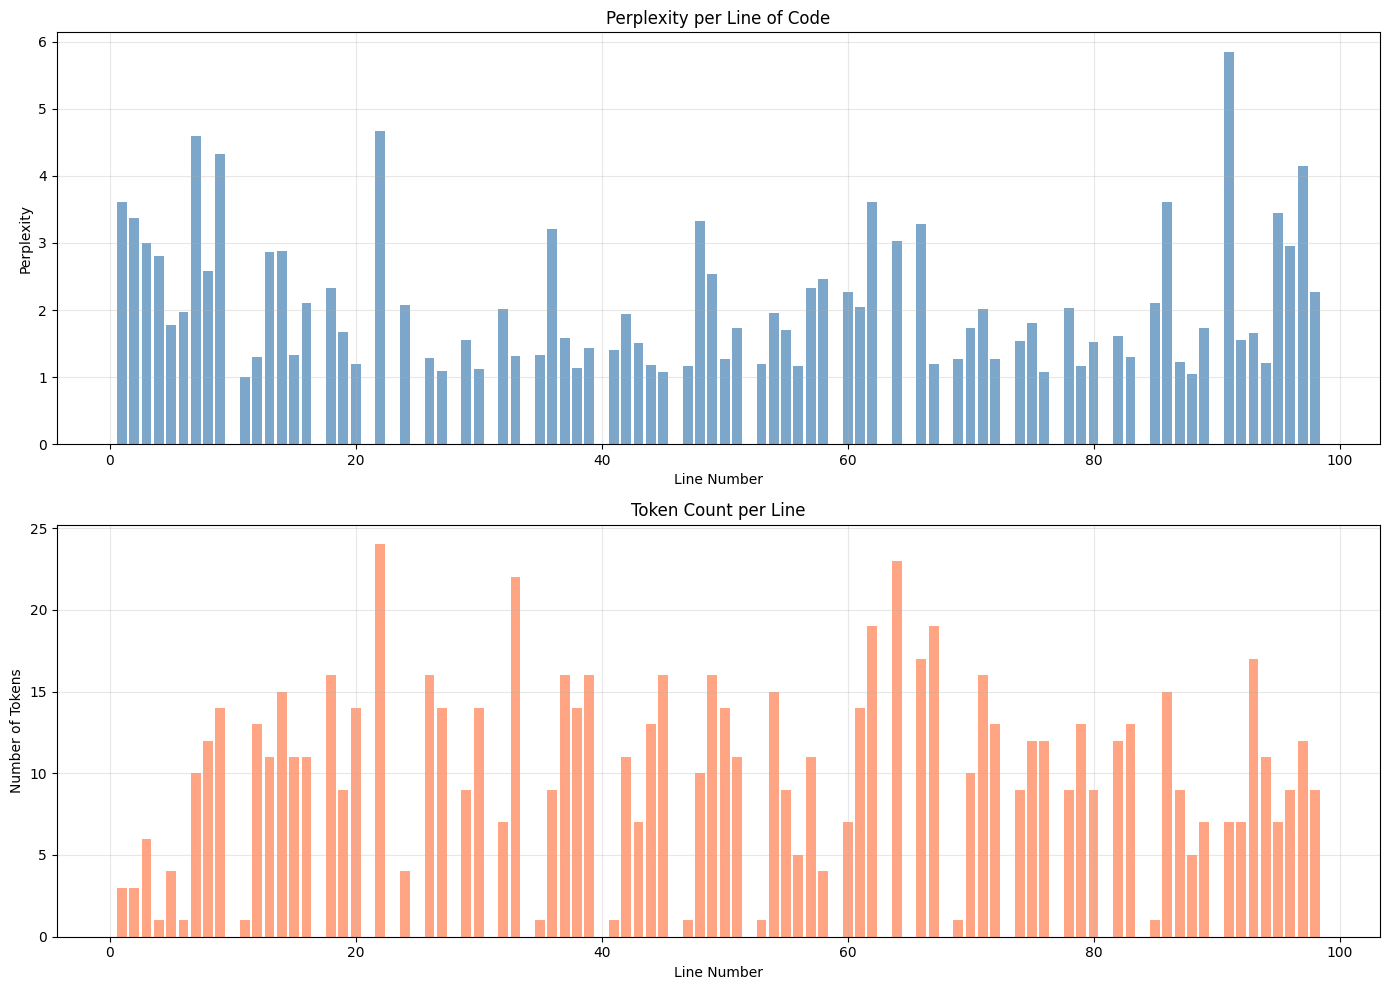


Line-Level Summary:
Mean Line Perplexity: 2.0899
Median Line Perplexity: 1.7328
Min Line Perplexity: 1.0001 (Line 11)
Max Line Perplexity: 5.8469 (Line 91)

Lines with highest perplexity (most surprising/complex):
    line  perplexity  num_tokens  \
70    91    5.846867           7   
18    22    4.668987          24   
6      7    4.591865          10   

                                         line_content  
70                                app.testing = False  
18      logging_plugin = pytestconfig.pluginmanage...  
6           from flask.logging import default_handler  


In [9]:
# Visualize per-line perplexity
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Perplexity per line
ax1 = axes[0]
ax1.bar(line_stats['line'], line_stats['perplexity'], color='steelblue', alpha=0.7)
ax1.set_xlabel('Line Number')
ax1.set_ylabel('Perplexity')
ax1.set_title('Perplexity per Line of Code')
ax1.grid(True, alpha=0.3)

# Plot 2: Number of tokens per line
ax2 = axes[1]
ax2.bar(line_stats['line'], line_stats['num_tokens'], color='coral', alpha=0.7)
ax2.set_xlabel('Line Number')
ax2.set_ylabel('Number of Tokens')
ax2.set_title('Token Count per Line')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nLine-Level Summary:")
print(f"Mean Line Perplexity: {line_stats['perplexity'].mean():.4f}")
print(f"Median Line Perplexity: {line_stats['perplexity'].median():.4f}")
print(f"Min Line Perplexity: {line_stats['perplexity'].min():.4f} (Line {line_stats.loc[line_stats['perplexity'].idxmin(), 'line']:.0f})")
print(f"Max Line Perplexity: {line_stats['perplexity'].max():.4f} (Line {line_stats.loc[line_stats['perplexity'].idxmax(), 'line']:.0f})")

print(f"\nLines with highest perplexity (most surprising/complex):")
print(line_stats.nlargest(3, 'perplexity')[['line', 'perplexity', 'num_tokens', 'line_content']])

In [10]:
# Assign weights based on perplexity scores
# Higher perplexity → Higher weight (more complex/surprising lines are more important)

# Method 1: Direct normalization (weights sum to 1)
line_stats['weight_normalized'] = line_stats['perplexity'] / line_stats['perplexity'].sum()

# Display weights comparison
weights_df = line_stats[['line', 'perplexity', 'weight_normalized',  'line_content']]

print("Weight Assignment Based on Perplexity:")
print("=" * 120)
print("\nMethods:")
print("  - weight_normalized: Direct normalization (weights sum to 1)")
print("  - weight_minmax: Min-Max scaling (0 to 1 range)")
print("  - weight_softmax: Softmax (exponential emphasis on high perplexity)")
print("  - weight_rank: Rank-based (ordinal ranking)")
print("\n")
weights_df

Weight Assignment Based on Perplexity:

Methods:
  - weight_normalized: Direct normalization (weights sum to 1)
  - weight_minmax: Min-Max scaling (0 to 1 range)
  - weight_softmax: Softmax (exponential emphasis on high perplexity)
  - weight_rank: Rank-based (ordinal ranking)




,line,perplexity,weight_normalized,line_content
0,1,3.612839,0.022163,import logging
1,2,3.368718,0.020665,import sys
2,3,3.000586,0.018407,from io import StringIO
3,4,2.807144,0.017220,
4,5,1.773974,0.010882,import pytest
...,...,...,...,...
73,94,1.214559,0.007451,assert rv.status_code == 500
74,95,3.445559,0.021137,assert rv.data
75,96,2.948866,0.018090,err = stream.getvalue()
76,97,4.144405,0.025424,"assert ""Exception on / [GET]"" in err"


In [11]:
# Weight-based masking: Higher weights → More tokens masked
# Using CodeBERT tokenizer for [MASK] token
import random
import numpy as np

def mask_line_tokens_weighted_codebert(line_text, mask_percentage):
    """
    Mask a percentage of tokens in a line using CodeBERT tokenizer.
    Excludes formatting tokens like '#', whitespace, and structural characters.
    
    Args:
        line_text: The line of code to mask
        mask_percentage: Percentage of maskable tokens to mask (based on weight)
    
    Returns:
        masked_text: Line with masked tokens
        mask_positions: List of token positions that were masked
        original_tokens: List of original tokens that were masked
    """
    if not line_text.strip():
        return line_text, [], []
    
    # Tokenize the line using CodeBERT tokenizer
    line_tokens = codebert_tokenizer(line_text, return_tensors="pt", add_special_tokens=False).input_ids[0]
    n_line_tokens = len(line_tokens)
    
    if n_line_tokens == 0:
        return line_text, [], []
    
    # Define tokens to exclude from masking
    exclude_tokens = set()
    
    # Get token IDs for formatting characters to exclude
    formatting_chars = [
        '#',           # Comments
        ' ',           # Spaces
        '\t',          # Tabs
        '\n',          # Newlines
        '\n\n',        # Multiple newlines
        '    ',        # Indentation (4 spaces)
        '        ',    # Indentation (8 spaces)
        '  ',          # Indentation (2 spaces)
        '}',
        '{'
        ']',
        '['
    ]
    
    for char in formatting_chars:
        try:
            token_ids = codebert_tokenizer(char, add_special_tokens=False).input_ids
            exclude_tokens.update(token_ids)
        except:
            pass
    
    # Exclude special tokens (RoBERTa special token IDs)
    exclude_tokens.update([0, 1, 2, 3, 4])
    
    # Find maskable positions (exclude formatting tokens and whitespace-only tokens)
    maskable_positions = []
    for i, token_id in enumerate(line_tokens):
        token_id_item = token_id.item()
        
        # Skip if in exclude list
        if token_id_item in exclude_tokens:
            continue
        
        # Decode token to check its content
        token_text = codebert_tokenizer.decode([token_id])
        
        # Skip if token is whitespace only
        if not token_text.strip():
            continue
        
        # Skip if token contains only '#' (comment symbol)
        if token_text.strip() == '#':
            continue
        
        # This token is maskable
        maskable_positions.append(i)
    
    # Calculate number of maskable tokens to mask
    n_maskable = len(maskable_positions)
    if n_maskable == 0:
        return line_text, [], []
    
    num_to_mask = max(1, int(n_maskable * mask_percentage))
    num_to_mask = min(num_to_mask, n_maskable)
    
    # Randomly select positions to mask from maskable positions
    positions_to_mask_idx = random.sample(range(n_maskable), num_to_mask)
    mask_positions = [maskable_positions[i] for i in positions_to_mask_idx]
    mask_positions.sort()
    
    # Store original tokens that will be masked
    original_tokens = []
    masked_token_ids = line_tokens.clone()
    
    # Use CodeBERT's [MASK] token
    mask_token_id = codebert_tokenizer.mask_token_id
    
    for pos in mask_positions:
        original_tokens.append({
            'position': pos,
            'token_id': line_tokens[pos].item(),
            'token_text': codebert_tokenizer.decode([line_tokens[pos]])
        })
        masked_token_ids[pos] = mask_token_id
    
    # Decode the masked line using CodeBERT tokenizer
    masked_text = codebert_tokenizer.decode(masked_token_ids, skip_special_tokens=False)
    
    return masked_text, mask_positions, original_tokens

# Weight-based masking configuration
random.seed(42)  # For reproducibility

# Base masking percentage
BASE_MASK_PCT = 0.15  # 15% base masking

# Apply weights to determine actual masking
# Higher weight → Multiply by factor > 1 (more masking)
# Lower weight → Multiply by factor < 1 (less masking)

# Calculate masking percentage for each line based on its weight
# We'll scale the base 15% by the relative weight
line_stats['mask_percentage'] = line_stats['weight_normalized'].apply(
    lambda w: BASE_MASK_PCT * (w / line_stats['weight_normalized'].mean())
)

# Clip to reasonable range (min 5%, max 30%)
line_stats['mask_percentage'] = line_stats['mask_percentage'].clip(0.05, 0.30)

masked_results = []

for idx, row in line_stats.iterrows():
    line_text = row['line_content']
    mask_pct = row['mask_percentage']
    
    masked_text, mask_pos, orig_tokens = mask_line_tokens_weighted_codebert(line_text, mask_pct)
    
    masked_results.append({
        'line': row['line'],
        'original_line': line_text,
        'masked_line': masked_text,
        'num_tokens': row['num_tokens'],
        'num_masked': len(mask_pos),
        'mask_percentage_actual': (len(mask_pos) / row['num_tokens'] * 100) if row['num_tokens'] > 0 else 0,
        'mask_percentage_target': mask_pct * 100,
        'masked_positions': mask_pos,
        'masked_tokens': orig_tokens,
        'perplexity': row['perplexity'],
        'weight': row['weight_normalized']
    })

masked_df = pd.DataFrame(masked_results)

print("=" * 120)
print("WEIGHT-BASED MASKING WITH CODEBERT (15% Base Rate × Weight Factor)")
print("=" * 120)
print(f"\nTotal lines: {len(masked_df)}")
print(f"Base masking: {BASE_MASK_PCT*100:.1f}% of tokens")
print(f"Weight adjustment: Lines scaled by relative weight (higher weight → more masking)")
print(f"Actual range: {masked_df['mask_percentage_target'].min():.1f}% to {masked_df['mask_percentage_target'].max():.1f}%")
print(f"Tokenizer: CodeBERT (microsoft/codebert-base)")
print(f"Mask token: {codebert_tokenizer.mask_token}\n")

# Display summary sorted by weight (descending)
display_cols = ['line', 'weight', 'perplexity', 'num_tokens', 'num_masked', 'mask_percentage_target', 'mask_percentage_actual']
summary_sorted = masked_df[display_cols].sort_values('weight', ascending=False)

print("\nSummary (sorted by weight - highest first):")
print(summary_sorted.to_string(index=False))

print("\n" + "=" * 120)
print("Sample Lines (Top 5 highest weighted = most masked):")
print("=" * 120)
top_weighted = masked_df.nlargest(5, 'weight')
for i, row in top_weighted.iterrows():
    print(f"\nLine {row['line']} (Weight: {row['weight']:.4f}, Perplexity: {row['perplexity']:.2f}):")
    print(f"  Original: {row['original_line']}")
    print(f"  Masked:   {row['masked_line']}")
    print(f"  Masked {row['num_masked']}/{row['num_tokens']} tokens ({row['mask_percentage_actual']:.1f}%)")

masked_df

WEIGHT-BASED MASKING WITH CODEBERT (15% Base Rate × Weight Factor)

Total lines: 78
Base masking: 15.0% of tokens
Weight adjustment: Lines scaled by relative weight (higher weight → more masking)
Actual range: 7.2% to 30.0%
Tokenizer: CodeBERT (microsoft/codebert-base)
Mask token: <mask>


Summary (sorted by weight - highest first):
 line   weight  perplexity  num_tokens  num_masked  mask_percentage_target  mask_percentage_actual
   91 0.035868    5.846867           7           1               30.000000               14.285714
   22 0.028642    4.668987          24           5               30.000000               20.833333
    7 0.028169    4.591865          10           2               30.000000               20.000000
    9 0.026517    4.322625          14           3               30.000000               21.428571
   97 0.025424    4.144405          12           2               29.745861               16.666667
    1 0.022163    3.612839           3           1               25.930

,line,original_line,masked_line,num_tokens,num_masked,mask_percentage_actual,mask_percentage_target,masked_positions,masked_tokens,perplexity,weight
0,1,import logging,<mask> logging,3,1,33.333333,25.930620,[0],"[{'position': 0, 'token_id': 41975, 'token_tex...",3.612839,0.022163
1,2,import sys,<mask> sys,3,1,33.333333,24.178476,[0],"[{'position': 0, 'token_id': 41975, 'token_tex...",3.368718,0.020665
2,3,from io import StringIO,from io<mask> StringIO,6,1,16.666667,21.536262,[2],"[{'position': 2, 'token_id': 6595, 'token_text...",3.000586,0.018407
3,4,,,1,0,0.000000,20.147860,[],[],2.807144,0.017220
4,5,import pytest,<mask> pytest,4,1,25.000000,12.732439,[0],"[{'position': 0, 'token_id': 41975, 'token_tex...",1.773974,0.010882
...,...,...,...,...,...,...,...,...,...,...,...
73,94,assert rv.status_code == 500,<mask> rv.status_code == 500,11,1,9.090909,8.717320,[3],"[{'position': 3, 'token_id': 18088, 'token_tex...",1.214559,0.007451
74,95,assert rv.data,assert<mask>v.data,7,1,14.285714,24.729993,[4],"[{'position': 4, 'token_id': 910, 'token_text'...",3.445559,0.021137
75,96,err = stream.getvalue(),<mask> = stream.getvalue(),9,1,11.111111,21.165050,[3],"[{'position': 3, 'token_id': 22379, 'token_tex...",2.948866,0.018090
76,97,"assert ""Exception on / [GET]"" in err","assert ""Exception on /<mask><mask>]"" in err",12,2,16.666667,29.745861,"[8, 9]","[{'position': 8, 'token_id': 646, 'token_text'...",4.144405,0.025424


In [12]:
# Nucleus Sampling for CodeBERT Perturbation
import torch.nn.functional as F

def nucleus_sampling(logits, top_p=0.95, temperature=1.0):
    """
    Apply nucleus (top-p) sampling to select a token from logits.
    
    Args:
        logits: Model output logits for masked position
        top_p: Cumulative probability threshold (default: 0.95)
        temperature: Sampling temperature (default: 1.0)
    
    Returns:
        Sampled token ID
    """
    # Apply temperature
    logits = logits / temperature
    
    # Convert to probabilities
    probs = F.softmax(logits, dim=-1)
    
    # Sort probabilities in descending order
    sorted_probs, sorted_indices = torch.sort(probs, descending=True)
    
    # Calculate cumulative probabilities
    cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
    
    # Remove tokens with cumulative probability above the threshold
    sorted_indices_to_remove = cumulative_probs > top_p
    
    # Shift the indices to the right to keep also the first token above the threshold
    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
    sorted_indices_to_remove[..., 0] = 0
    
    # Set probabilities of removed indices to 0
    sorted_probs[sorted_indices_to_remove] = 0.0
    
    # Renormalize probabilities
    sorted_probs = sorted_probs / sorted_probs.sum()
    
    # Sample from the filtered distribution
    sampled_index = torch.multinomial(sorted_probs, num_samples=1)
    sampled_token_id = sorted_indices[sampled_index]
    
    return sampled_token_id.item()


def generate_perturbations_for_masked_line(masked_line, num_perturbations=2, top_p=0.95, temperature=1.0):
    """
    Generate perturbations for a masked line using CodeBERT with nucleus sampling.
    
    Args:
        masked_line: Line with [MASK] tokens
        num_perturbations: Number of perturbations to generate (default: 2)
        top_p: Nucleus sampling threshold (default: 0.95)
        temperature: Sampling temperature (default: 1.0)
    
    Returns:
        List of perturbed lines
    """
    perturbations = []
    
    # Tokenize the masked line
    inputs = codebert_tokenizer(masked_line, return_tensors="pt", add_special_tokens=True)
    input_ids = inputs['input_ids'].to(device)
    
    # Find positions of [MASK] tokens
    mask_token_id = codebert_tokenizer.mask_token_id
    mask_positions = (input_ids[0] == mask_token_id).nonzero(as_tuple=True)[0]
    
    if len(mask_positions) == 0:
        # No masks, return original line
        return [masked_line] * num_perturbations
    
    # Generate multiple perturbations
    for pert_idx in range(num_perturbations):
        perturbed_ids = input_ids.clone()
        
        # Get model predictions
        with torch.no_grad():
            outputs = codebert_model(perturbed_ids)
            predictions = outputs.logits  # Shape: [batch_size, seq_len, vocab_size]
        
        # For each [MASK] position, sample a token using nucleus sampling
        for mask_pos in mask_positions:
            # Get logits for this masked position
            mask_logits = predictions[0, mask_pos, :]
            
            # Sample using nucleus sampling
            sampled_token_id = nucleus_sampling(mask_logits, top_p=top_p, temperature=temperature)
            
            # Replace the [MASK] token with sampled token
            perturbed_ids[0, mask_pos] = sampled_token_id
        
        # Decode the perturbed line
        perturbed_line = codebert_tokenizer.decode(perturbed_ids[0], skip_special_tokens=True)
        perturbations.append(perturbed_line)
    
    return perturbations

print("✓ Nucleus sampling and perturbation functions loaded")

✓ Nucleus sampling and perturbation functions loaded


In [19]:
# Generate perturbations for all masked lines
import time

# Configuration for perturbation
NUM_PERTURBATIONS = 50
TOP_P = 0.5  # Nucleus sampling threshold
TEMPERATURE = 0.9  # Sampling temperature

print("=" * 120)
print(f"GENERATING PERTURBATIONS USING CODEBERT WITH NUCLEUS SAMPLING")
print("=" * 120)
print(f"Number of perturbations per line: {NUM_PERTURBATIONS}")
print(f"Sampling method: Nucleus sampling (top-p={TOP_P}, temperature={TEMPERATURE})")
print(f"Total masked lines: {len(masked_df)}")
print("\n")

perturbation_results = []

start_time = time.time()

for idx, row in masked_df.iterrows():
    masked_line = row['masked_line']
    
    # Skip lines with no masks
    if '<mask>' not in masked_line.lower() and '[MASK]' not in masked_line:
        perturbations = [row['original_line']] * NUM_PERTURBATIONS
    else:
        # Generate perturbations
        perturbations = generate_perturbations_for_masked_line(
            masked_line, 
            num_perturbations=NUM_PERTURBATIONS,
            top_p=TOP_P,
            temperature=TEMPERATURE
        )
    
    # Build result dictionary dynamically
    result = {
        'line': row['line'],
        'original_line': row['original_line'],
        'masked_line': masked_line,
        'num_masked': row['num_masked'],
        'perplexity': row['perplexity'],
        'weight': row['weight']
    }
    
    # Add perturbations dynamically
    for i, pert in enumerate(perturbations, start=1):
        result[f'perturbation_{i}'] = pert
    
    perturbation_results.append(result)
    
    # Progress indicator
    if (idx + 1) % 10 == 0:
        print(f"Processed {idx + 1}/{len(masked_df)} lines...")

end_time = time.time()

perturbation_df = pd.DataFrame(perturbation_results)

print(f"\n✓ Perturbation generation complete!")
print(f"Time taken: {end_time - start_time:.2f} seconds")
print(f"Average time per line: {(end_time - start_time) / len(masked_df):.3f} seconds")

print("\n" + "=" * 120)
print("SAMPLE PERTURBATIONS (Top 5 highest weighted lines):")
print("=" * 120)

top_samples = perturbation_df.nlargest(5, 'weight')
for i, row in top_samples.iterrows():
    print(f"\nLine {row['line']} (Weight: {row['weight']:.4f}, Perplexity: {row['perplexity']:.2f}):")
    print(f"  Original:        {row['original_line']}")
    print(f"  Masked:          {row['masked_line']}")
    
    # Print perturbations dynamically
    for j in range(1, NUM_PERTURBATIONS + 1):
        pert_col = f'perturbation_{j}'
        if pert_col in row:
            print(f"  Perturbation {j}:  {row[pert_col]}")

perturbation_df

GENERATING PERTURBATIONS USING CODEBERT WITH NUCLEUS SAMPLING
Number of perturbations per line: 50
Sampling method: Nucleus sampling (top-p=0.5, temperature=0.9)
Total masked lines: 78


Processed 10/78 lines...
Processed 10/78 lines...
Processed 20/78 lines...
Processed 20/78 lines...
Processed 30/78 lines...
Processed 30/78 lines...
Processed 40/78 lines...
Processed 40/78 lines...
Processed 50/78 lines...
Processed 50/78 lines...
Processed 60/78 lines...
Processed 60/78 lines...
Processed 70/78 lines...
Processed 70/78 lines...

✓ Perturbation generation complete!
Time taken: 67.16 seconds
Average time per line: 0.861 seconds

SAMPLE PERTURBATIONS (Top 5 highest weighted lines):

Line 91 (Weight: 0.0359, Perplexity: 5.85):
  Original:            app.testing = False
  Masked:              app.<mask> = False
  Perturbation 1:      app.debug = False
  Perturbation 2:      app.debug = False
  Perturbation 3:      app.debug = False
  Perturbation 4:      app.debug = False
  Perturbation 

,line,original_line,masked_line,num_masked,perplexity,weight,perturbation_1,perturbation_2,perturbation_3,perturbation_4,...,perturbation_41,perturbation_42,perturbation_43,perturbation_44,perturbation_45,perturbation_46,perturbation_47,perturbation_48,perturbation_49,perturbation_50
0,1,import logging,<mask> logging,1,3.612839,0.022163,for logging,the logging,of logging,custom logging,...,for logging,add logging,logging logging,debug logging,level logging,configure logging,debug logging,. logging,the logging,log logging
1,2,import sys,<mask> sys,1,3.368718,0.020665,= sys,= sys,= sys,= sys,...,= sys,= sys,= sys,= sys,= sys,= sys,= sys,= sys,= sys,= sys
2,3,from io import StringIO,from io<mask> StringIO,1,3.000586,0.018407,from io import StringIO,from io import StringIO,from io import StringIO,from io import StringIO,...,from io import StringIO,from io import StringIO,from io import StringIO,from io import StringIO,from io import StringIO,from io import StringIO,from io import StringIO,from io import StringIO,from io import StringIO,from io import StringIO
3,4,,,0,2.807144,0.017220,,,,,...,,,,,,,,,,
4,5,import pytest,<mask> pytest,1,1.773974,0.010882,import pytest,in pytest,import pytest,. pytest,...,. pytest,in pytest,= pytest,in pytest,import pytest,. pytest,import pytest,import pytest,import pytest,import pytest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,94,assert rv.status_code == 500,<mask> rv.status_code == 500,1,1.214559,0.007451,if rv.status_code == 500,if rv.status_code == 500,and rv.status_code == 500,if rv.status_code == 500,...,if rv.status_code == 500,if rv.status_code == 500,if rv.status_code == 500,if rv.status_code == 500,if rv.status_code == 500,if rv.status_code == 500,and rv.status_code == 500,and rv.status_code == 500,and rv.status_code == 500,if rv.status_code == 500
74,95,assert rv.data,assert<mask>v.data,1,3.445559,0.021137,assert rv.data,assert rv.data,assert rv.data,assert rv.data,...,assert rv.data,assert rv.data,assert rv.data,assert dv.data,assert rv.data,assert rv.data,assert rv.data,assert rv.data,assert kv.data,assert dv.data
75,96,err = stream.getvalue(),<mask> = stream.getvalue(),1,2.948866,0.018090,value = stream.getvalue(),value = stream.getvalue(),value = stream.getvalue(),value = stream.getvalue(),...,value = stream.getvalue(),value = stream.getvalue(),value = stream.getvalue(),value = stream.getvalue(),value = stream.getvalue(),value = stream.getvalue(),value = stream.getvalue(),value = stream.getvalue(),value = stream.getvalue(),value = stream.getvalue()
76,97,"assert ""Exception on / [GET]"" in err","assert ""Exception on /<mask><mask>]"" in err",2,4.144405,0.025424,"assert ""Exception on /[dir]"" in err","assert ""Exception on /[url]"" in err","assert ""Exception on /[path]"" in err","assert ""Exception on /[name]"" in err",...,"assert ""Exception on /[file]"" in err","assert ""Exception on /[path]"" in err","assert ""Exception on /[path]"" in err","assert ""Exception on /[url]"" in err","assert ""Exception on /[file]"" in err","assert ""Exception on /[}]"" in err","assert ""Exception on /[/]"" in err","assert ""Exception on /[name]"" in err","assert ""Exception on /[file]"" in err","assert ""Exception on /[url]"" in err"


In [20]:
# Calculate perplexity scores for each perturbed line
import time

def calculate_line_perplexity(line_text, tokenizer, model):
    """
    Calculate perplexity for a single line of code.
    
    Args:
        line_text: The line of code to evaluate
        tokenizer: HuggingFace tokenizer
        model: HuggingFace causal LM model
    
    Returns:
        Perplexity score (float)
    """
    # Handle non-string inputs
    if not isinstance(line_text, str):
        return 1.0
    
    if not line_text.strip():
        return 1.0  # Return 1.0 for empty lines instead of inf
    
    # Get device from model
    device = next(model.parameters()).device
    
    # Tokenize the line
    tokens = tokenizer(line_text, return_tensors="pt").input_ids[0]
    n_tokens = len(tokens)
    
    if n_tokens < 2:
        return 1.0  # Return 1.0 for single tokens instead of inf
    
    tokens = tokens.to(device)
    
    # Calculate log probabilities
    with torch.no_grad():
        outputs = model(tokens.unsqueeze(0), labels=tokens.unsqueeze(0))
        logits = outputs.logits
    
    # Get predictions for positions 1 to n
    shift_logits = logits[0, :-1, :]  # Predictions for next token
    shift_labels = tokens[1:]          # Actual next tokens
    
    # Convert to probabilities
    probs = torch.softmax(shift_logits, dim=-1)
    
    # Get probability of actual tokens
    actual_probs = torch.gather(probs, 1, shift_labels.unsqueeze(1)).squeeze(1)
    
    # Clamp probabilities to avoid log(0) = -inf
    actual_probs = torch.clamp(actual_probs, min=1e-10)
    
    # Calculate log probabilities
    log_probs = torch.log(actual_probs)
    
    # Calculate perplexity: exp(-1/N * Σ log p(w_j))
    avg_log_prob = log_probs.sum() / len(log_probs)
    perplexity = torch.exp(-avg_log_prob).item()
    
    # Clamp perplexity to reasonable range to avoid inf
    perplexity = min(perplexity, 1e6)
    
    return perplexity


print("=" * 120)
print("CALCULATING PERPLEXITY SCORES FOR PERTURBED LINES")
print("=" * 120)
print(f"Using model: Salesforce/codegen-350M-mono")
print(f"Total lines to evaluate: {len(perturbation_df)} lines × {NUM_PERTURBATIONS} perturbations = {len(perturbation_df) * NUM_PERTURBATIONS} evaluations")
print("\n")

start_time = time.time()

# Dynamically calculate perplexity for each perturbation column
perturbation_columns = [col for col in perturbation_df.columns if col.startswith('perturbation_')]

for pert_col in perturbation_columns:
    perplexity_col = f'{pert_col}_perplexity'
    perturbation_df[perplexity_col] = 0.0
    
    for idx, row in perturbation_df.iterrows():
        pert_ppl = calculate_line_perplexity(row[pert_col], tokenizer, model)
        perturbation_df.at[idx, perplexity_col] = pert_ppl
        
        # Progress indicator (show once per line, not per perturbation)
        if pert_col == perturbation_columns[0] and (idx + 1) % 10 == 0:
            print(f"Processed {idx + 1}/{len(perturbation_df)} lines...")

end_time = time.time()

print(f"\n✓ Perplexity calculation complete!")
print(f"Time taken: {end_time - start_time:.2f} seconds")
print(f"Average time per line: {(end_time - start_time) / len(perturbation_df):.3f} seconds")

# Add comparison columns
perturbation_df['original_perplexity'] = perturbation_df['perplexity']  # Rename for clarity


print("=" * 120)

top_samples = perturbation_df.nlargest(5, 'weight')
for i, row in top_samples.iterrows():
    print(f"\nLine {row['line']} (Weight: {row['weight']:.4f}):")
    print(f"  Original:        {row['original_line']}")
    print(f"  Original PPL:    {row['original_perplexity']:.2f}")
    
    # Print perturbations dynamically
    for j in range(1, NUM_PERTURBATIONS + 1):
        pert_col = f'perturbation_{j}'
        pert_ppl_col = f'{pert_col}_perplexity'
        if pert_col in row and pert_ppl_col in row:
            print(f"  {pert_col.replace('_', ' ').title()}:  {row[pert_col]}")
            print(f"  Pert{j} PPL:       {row[pert_ppl_col]:.2f}")



perturbation_df

CALCULATING PERPLEXITY SCORES FOR PERTURBED LINES
Using model: Salesforce/codegen-350M-mono
Total lines to evaluate: 78 lines × 50 perturbations = 3900 evaluations


Processed 10/78 lines...
Processed 10/78 lines...
Processed 20/78 lines...
Processed 20/78 lines...
Processed 30/78 lines...
Processed 30/78 lines...
Processed 40/78 lines...
Processed 40/78 lines...
Processed 50/78 lines...
Processed 50/78 lines...
Processed 60/78 lines...
Processed 60/78 lines...
Processed 70/78 lines...
Processed 70/78 lines...

✓ Perplexity calculation complete!
Time taken: 185.07 seconds
Average time per line: 2.373 seconds

Line 91 (Weight: 0.0359):
  Original:            app.testing = False
  Original PPL:    5.85
  Perturbation 1:      app.debug = False
  Pert1 PPL:       13.78
  Perturbation 2:      app.debug = False
  Pert2 PPL:       13.78
  Perturbation 3:      app.debug = False
  Pert3 PPL:       13.78
  Perturbation 4:      app.debug = False
  Pert4 PPL:       13.78
  Perturbation 5:      app

,line,original_line,masked_line,num_masked,perplexity,weight,perturbation_1,perturbation_2,perturbation_3,perturbation_4,...,perturbation_42_perplexity,perturbation_43_perplexity,perturbation_44_perplexity,perturbation_45_perplexity,perturbation_46_perplexity,perturbation_47_perplexity,perturbation_48_perplexity,perturbation_49_perplexity,perturbation_50_perplexity,original_perplexity
0,1,import logging,<mask> logging,1,3.612839,0.022163,for logging,the logging,of logging,custom logging,...,6923.622070,6526.552734,663.870056,6366.573730,90.051476,663.870056,198264.468750,2317.921875,3036.101807,3.612839
1,2,import sys,<mask> sys,1,3.368718,0.020665,= sys,= sys,= sys,= sys,...,1101.747681,1101.747681,1101.747681,1101.747681,1101.747681,1101.747681,1101.747681,1101.747681,1101.747681,3.368718
2,3,from io import StringIO,from io<mask> StringIO,1,3.000586,0.018407,from io import StringIO,from io import StringIO,from io import StringIO,from io import StringIO,...,6.666202,6.666202,6.666202,6.666202,6.666202,6.666202,6.666202,6.666202,6.666202,3.000586
3,4,,,0,2.807144,0.017220,,,,,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.807144
4,5,import pytest,<mask> pytest,1,1.773974,0.010882,import pytest,in pytest,import pytest,. pytest,...,115.965874,71.951202,115.965874,24.572971,123.316307,24.572971,24.572971,24.572971,24.572971,1.773974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,94,assert rv.status_code == 500,<mask> rv.status_code == 500,1,1.214559,0.007451,if rv.status_code == 500,if rv.status_code == 500,and rv.status_code == 500,if rv.status_code == 500,...,9.186833,9.186833,9.186833,9.186833,9.186833,15.313394,15.313394,15.313394,9.186833,1.214559
74,95,assert rv.data,assert<mask>v.data,1,3.445559,0.021137,assert rv.data,assert rv.data,assert rv.data,assert rv.data,...,13.967032,13.967032,36.353424,13.967032,13.967032,13.967032,13.967032,63.609383,36.353424,3.445559
75,96,err = stream.getvalue(),<mask> = stream.getvalue(),1,2.948866,0.018090,value = stream.getvalue(),value = stream.getvalue(),value = stream.getvalue(),value = stream.getvalue(),...,28.690004,28.690004,28.690004,28.690004,12.993874,12.993874,28.690004,12.993874,28.690004,2.948866
76,97,"assert ""Exception on / [GET]"" in err","assert ""Exception on /<mask><mask>]"" in err",2,4.144405,0.025424,"assert ""Exception on /[dir]"" in err","assert ""Exception on /[url]"" in err","assert ""Exception on /[path]"" in err","assert ""Exception on /[name]"" in err",...,78.700363,78.700363,96.228828,96.621544,100.465042,98.463875,79.031677,96.621544,96.228828,4.144405


In [21]:
# Add standard deviation columns for each perplexity type
print("=" * 120)
print("ADDING STANDARD DEVIATION COLUMNS")
print("=" * 120)

# Calculate standard deviation for original perplexity
original_std = perturbation_df['original_perplexity'].std()
perturbation_df['original_perplexity_std'] = original_std

print(f"\nStandard Deviation Values:")
print(f"  Original Perplexity Std Dev:        {original_std:.4f}")

# Dynamically calculate std dev for all perturbation perplexity columns
perturbation_perplexity_cols = [col for col in perturbation_df.columns 
                                if col.startswith('perturbation_') and col.endswith('_perplexity')]

for pert_ppl_col in perturbation_perplexity_cols:
    std_col = f'{pert_ppl_col}_std'
    std_value = perturbation_df[pert_ppl_col].std()
    perturbation_df[std_col] = std_value
    
    # Extract perturbation number for display
    pert_num = pert_ppl_col.split('_')[1]
    print(f"  Perturbation {pert_num} Perplexity Std Dev:  {std_value:.4f}")

print("\n✓ Standard deviation columns added to dataframe!")
print(f"\nNew columns ({1 + len(perturbation_perplexity_cols)} total):")
print("  - 'original_perplexity_std'")
for pert_ppl_col in perturbation_perplexity_cols:
    print(f"  - '{pert_ppl_col}_std'")

# Display sample with new columns dynamically
print("\n" + "=" * 120)
print("SAMPLE DATA WITH STANDARD DEVIATION COLUMNS (First 5 rows):")
print("=" * 120)

# Build display columns dynamically
display_cols = ['line', 'original_perplexity', 'original_perplexity_std']
for i in range(1, NUM_PERTURBATIONS + 1):
    display_cols.append(f'perturbation_{i}_perplexity')
    display_cols.append(f'perturbation_{i}_perplexity_std')

# Only show columns that exist
display_cols = [col for col in display_cols if col in perturbation_df.columns]
print(perturbation_df[display_cols].head().to_string(index=False))

perturbation_df

ADDING STANDARD DEVIATION COLUMNS

Standard Deviation Values:
  Original Perplexity Std Dev:        1.0198
  Perturbation 1 Perplexity Std Dev:  206.0116
  Perturbation 2 Perplexity Std Dev:  288.8386
  Perturbation 3 Perplexity Std Dev:  412.8713
  Perturbation 4 Perplexity Std Dev:  318.1394
  Perturbation 5 Perplexity Std Dev:  343.1083
  Perturbation 6 Perplexity Std Dev:  313.0550
  Perturbation 7 Perplexity Std Dev:  834.7601
  Perturbation 8 Perplexity Std Dev:  180.3465
  Perturbation 9 Perplexity Std Dev:  22444.5434
  Perturbation 10 Perplexity Std Dev:  344.3221
  Perturbation 11 Perplexity Std Dev:  363.2337
  Perturbation 12 Perplexity Std Dev:  22444.6033
  Perturbation 13 Perplexity Std Dev:  364.5016
  Perturbation 14 Perplexity Std Dev:  22444.8089
  Perturbation 15 Perplexity Std Dev:  22444.6217
  Perturbation 16 Perplexity Std Dev:  22444.4644
  Perturbation 17 Perplexity Std Dev:  151.3957
  Perturbation 18 Perplexity Std Dev:  147.9619
  Perturbation 19 Perplexity

C:\Users\MSI\AppData\Local\Temp\ipykernel_15960\1440358339.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  perturbation_df[std_col] = std_value
C:\Users\MSI\AppData\Local\Temp\ipykernel_15960\1440358339.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  perturbation_df[std_col] = std_value
C:\Users\MSI\AppData\Local\Temp\ipykernel_15960\1440358339.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all co

,line,original_line,masked_line,num_masked,perplexity,weight,perturbation_1,perturbation_2,perturbation_3,perturbation_4,...,perturbation_41_perplexity_std,perturbation_42_perplexity_std,perturbation_43_perplexity_std,perturbation_44_perplexity_std,perturbation_45_perplexity_std,perturbation_46_perplexity_std,perturbation_47_perplexity_std,perturbation_48_perplexity_std,perturbation_49_perplexity_std,perturbation_50_perplexity_std
0,1,import logging,<mask> logging,1,3.612839,0.022163,for logging,the logging,of logging,custom logging,...,206.107966,790.036184,746.051696,314.053465,776.53145,130.205718,315.532891,22444.683491,398.763982,364.481146
1,2,import sys,<mask> sys,1,3.368718,0.020665,= sys,= sys,= sys,= sys,...,206.107966,790.036184,746.051696,314.053465,776.53145,130.205718,315.532891,22444.683491,398.763982,364.481146
2,3,from io import StringIO,from io<mask> StringIO,1,3.000586,0.018407,from io import StringIO,from io import StringIO,from io import StringIO,from io import StringIO,...,206.107966,790.036184,746.051696,314.053465,776.53145,130.205718,315.532891,22444.683491,398.763982,364.481146
3,4,,,0,2.807144,0.017220,,,,,...,206.107966,790.036184,746.051696,314.053465,776.53145,130.205718,315.532891,22444.683491,398.763982,364.481146
4,5,import pytest,<mask> pytest,1,1.773974,0.010882,import pytest,in pytest,import pytest,. pytest,...,206.107966,790.036184,746.051696,314.053465,776.53145,130.205718,315.532891,22444.683491,398.763982,364.481146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,94,assert rv.status_code == 500,<mask> rv.status_code == 500,1,1.214559,0.007451,if rv.status_code == 500,if rv.status_code == 500,and rv.status_code == 500,if rv.status_code == 500,...,206.107966,790.036184,746.051696,314.053465,776.53145,130.205718,315.532891,22444.683491,398.763982,364.481146
74,95,assert rv.data,assert<mask>v.data,1,3.445559,0.021137,assert rv.data,assert rv.data,assert rv.data,assert rv.data,...,206.107966,790.036184,746.051696,314.053465,776.53145,130.205718,315.532891,22444.683491,398.763982,364.481146
75,96,err = stream.getvalue(),<mask> = stream.getvalue(),1,2.948866,0.018090,value = stream.getvalue(),value = stream.getvalue(),value = stream.getvalue(),value = stream.getvalue(),...,206.107966,790.036184,746.051696,314.053465,776.53145,130.205718,315.532891,22444.683491,398.763982,364.481146
76,97,"assert ""Exception on / [GET]"" in err","assert ""Exception on /<mask><mask>]"" in err",2,4.144405,0.025424,"assert ""Exception on /[dir]"" in err","assert ""Exception on /[url]"" in err","assert ""Exception on /[path]"" in err","assert ""Exception on /[name]"" in err",...,206.107966,790.036184,746.051696,314.053465,776.53145,130.205718,315.532891,22444.683491,398.763982,364.481146


In [22]:
import numpy as np

def calculate_burstiness(lines_data):
    """
    Calculate burstiness based on sentence/line structure and length predictability.
    
    Burstiness measures how unpredictable the line lengths are:
    - High burstiness = High variance in line lengths (unpredictable structure)
    - Low burstiness = Low variance in line lengths (predictable, uniform structure)
    
    Formula: Burstiness = (σ² - μ) / (σ² + μ)
    where σ² is variance and μ is mean of line lengths
    
    Args:
        lines_data: List of lines or DataFrame with line content
    
    Returns:
        Burstiness score (range: -1 to 1)
        - Values close to 1: High burstiness (unpredictable, varying lengths)
        - Values close to 0: Medium burstiness
        - Values close to -1: Low burstiness (predictable, uniform lengths)
    """
    # Extract line lengths (number of characters per line)
    if isinstance(lines_data, pd.DataFrame):
        if 'original_line' in lines_data.columns:
            line_lengths = lines_data['original_line'].apply(len).values
        elif 'line_content' in lines_data.columns:
            line_lengths = lines_data['line_content'].apply(len).values
        else:
            raise ValueError("DataFrame must contain 'original_line' or 'line_content' column")
    else:
        # Assume it's a list of strings
        line_lengths = np.array([len(line) for line in lines_data])
    
    if len(line_lengths) == 0:
        return 0.0
    
    # Calculate mean and variance of line lengths
    mean_length = np.mean(line_lengths)
    variance_length = np.var(line_lengths)
    
    # Burstiness formula: (σ² - μ) / (σ² + μ)
    # Prevents division by zero
    if variance_length + mean_length == 0:
        return 0.0
    
    burstiness = (variance_length - mean_length) / (variance_length + mean_length)
    
    # Clip to valid range [-1, 1]
    burstiness = np.clip(burstiness, -1, 1)
    
    return burstiness


In [23]:
# Create simplified overall metrics summary with final scoring
def get_overall_metrics_summary(perturbation_df, alpha=0.4, beta=0.3, gamma=0.3):
    """
    Generate overall metrics summary with:
    - Sum of perplexity for original and each perturbation
    - Standard deviation for each perturbation
    - Burstiness for original and each perturbation
    - Final Score using formula: scoring = α×PPL + β×Std(PPL) + γ×B
    
    Args:
        perturbation_df: DataFrame with original and perturbed lines
        alpha: Weight for sum of perplexity (default: 0.4)
        beta: Weight for standard deviation (default: 0.3)
        gamma: Weight for burstiness (default: 0.3)
    
    Returns:
        Tuple of (metrics_df, scores_df)
    """
    print("=" * 120)
    print("OVERALL METRICS SUMMARY")
    print("=" * 120)
    print(f"\nScoring Formula: α×PPL + β×Std(PPL) + γ×B")
    print(f"  α (PPL weight) = {alpha}")
    print(f"  β (Std weight) = {beta}")
    print(f"  γ (Burstiness weight) = {gamma}")
    print("=" * 120)
    
    # Find all perturbation columns dynamically
    perturbation_cols = [col for col in perturbation_df.columns 
                        if col.startswith('perturbation_') 
                        and not col.endswith('_perplexity') 
                        and not col.endswith('_std')]
    
    # Initialize metrics dictionary
    metrics_dict = {}
    scores_dict = {}
    
    # Original metrics - use 'perplexity' column (will become 'original_perplexity' after cell 14 runs)
    original_ppl_col = 'original_perplexity' if 'original_perplexity' in perturbation_df.columns else 'perplexity'
    original_sum_ppl = perturbation_df[original_ppl_col].sum()
    original_std_ppl = perturbation_df[original_ppl_col].std()
    original_burstiness = calculate_burstiness(perturbation_df)
    
    metrics_dict['Sum_of_Perplexity_Original'] = original_sum_ppl
    metrics_dict['Standard_Deviation_Original'] = original_std_ppl
    metrics_dict['Burstiness_Original'] = original_burstiness
    
    # Calculate original score
    original_score = (alpha * original_sum_ppl) + (beta * original_std_ppl) + (gamma * original_burstiness)
    scores_dict['Score_Original'] = original_score
    
    # Perturbation metrics (dynamically)
    for i in range(1, len(perturbation_cols) + 1):
        pert_col = f'perturbation_{i}'
        pert_ppl_col = f'{pert_col}_perplexity'
        
        if pert_ppl_col in perturbation_df.columns:
            # Sum of perplexity
            sum_ppl = perturbation_df[pert_ppl_col].sum()
            metrics_dict[f'Sum_of_Perplexity_Perturbation_{i}'] = sum_ppl
            
            # Standard deviation
            std_ppl = perturbation_df[pert_ppl_col].std()
            metrics_dict[f'Standard_Deviation_Perturbation_{i}'] = std_ppl
            
            # Burstiness
            burstiness = 0.0
            if pert_col in perturbation_df.columns:
                burstiness = calculate_burstiness(perturbation_df[pert_col].tolist())
                metrics_dict[f'Burstiness_Perturbation_{i}'] = burstiness
            
            # Calculate score for this perturbation
            score = (alpha * sum_ppl) + (beta * std_ppl) + (gamma * burstiness)
            scores_dict[f'Score_Perturbation_{i}'] = score
    
    # Create DataFrame from metrics
    metrics_df = pd.DataFrame(list(metrics_dict.items()), columns=['Metric', 'Value'])
    
    print("\n" + "=" * 120)
    print("DETAILED METRICS:")
    print("=" * 120)
    print(metrics_df.to_string(index=False))
    
    # Create scores DataFrame
    scores_df = pd.DataFrame(list(scores_dict.items()), columns=['Category', 'Final_Score'])
    
    print("\n" + "=" * 120)
    print("FINAL SCORES:")
    print("=" * 120)
    print(scores_df.to_string(index=False))
    
    print("\n" + "=" * 120)
    print("METRIC DESCRIPTIONS:")
    print("=" * 120)
    print("• Sum of Perplexity (PPL): Total perplexity across all lines (higher = more complex/surprising)")
    print("• Standard Deviation (Std): Variability in perplexity scores (higher = more inconsistent)")
    print("• Burstiness (B): Line length predictability (close to 1 = unpredictable, close to -1 = uniform)")
    print("• Final Score: Weighted combination = α×PPL + β×Std(PPL) + γ×B")
    print("=" * 120)
    
    return metrics_df, scores_df

# Generate overall metrics summary with default weights (α=0.4, β=0.3, γ=0.3)
# You can change the weights by passing different values: get_overall_metrics_summary(perturbation_df, alpha=0.5, beta=0.3, gamma=0.2)
overall_metrics, final_scores = get_overall_metrics_summary(perturbation_df)

print("\n" + "=" * 120)
print("SCORE COMPARISON:")
print("=" * 120)
final_scores

OVERALL METRICS SUMMARY

Scoring Formula: α×PPL + β×Std(PPL) + γ×B
  α (PPL weight) = 0.4
  β (Std weight) = 0.3
  γ (Burstiness weight) = 0.3

DETAILED METRICS:
                            Metric         Value
        Sum_of_Perplexity_Original    163.012741
       Standard_Deviation_Original      1.019834
               Burstiness_Original      0.819551
  Sum_of_Perplexity_Perturbation_1   4827.222433
 Standard_Deviation_Perturbation_1    206.011615
         Burstiness_Perturbation_1      0.822155
  Sum_of_Perplexity_Perturbation_2   5449.631853
 Standard_Deviation_Perturbation_2    288.838554
         Burstiness_Perturbation_2      0.829655
  Sum_of_Perplexity_Perturbation_3   6364.769894
 Standard_Deviation_Perturbation_3    412.871342
         Burstiness_Perturbation_3      0.826632
  Sum_of_Perplexity_Perturbation_4   6450.562291
 Standard_Deviation_Perturbation_4    318.139440
         Burstiness_Perturbation_4      0.825230
  Sum_of_Perplexity_Perturbation_5   6797.315127
 Stan

,Category,Final_Score
0,Score_Original,65.756912
1,Score_Perturbation_1,1992.939104
2,Score_Perturbation_2,2266.753204
3,Score_Perturbation_3,2670.017350
4,Score_Perturbation_4,2675.914317
5,Score_Perturbation_5,2822.106936
6,Score_Perturbation_6,2535.190091
7,Score_Perturbation_7,5262.964591
8,Score_Perturbation_8,1873.413685
9,Score_Perturbation_9,87368.978410


In [24]:
import pandas as pd

def calculate_score_comparison(scores_df):
    """
    Calculate percentage of perturbation scores > original score.
    Formula: (Count > original) / Total perturbations × 100
    """
    # Extract scores
    original_score = scores_df[scores_df['Category'] == 'Score_Original']['Final_Score'].values[0]
    perturbation_scores = scores_df[
        scores_df['Category'].str.startswith('Score_Perturbation')
    ]['Final_Score'].values
    
    # Calculate
    count_greater = sum(perturbation_scores > original_score)
    total_perturbations = len(perturbation_scores)  # Only perturbations
    prediction_probability = float(count_greater/ total_perturbations)
    if prediction_probability >0.97:
        print(f"COde is generated by AI: score ={prediction_probability}")
    else:
        print(f"COde is generated by Human: score ={prediction_probability}")

calculate_score_comparison(final_scores)


COde is generated by AI: score =1.0
